Last updated: Arjun (11/11/24)

# Imports

In [1]:
%reload_ext autoreload
%autoreload 2


from imports import *
from sparam import read_s4p, read_s2p, interpolate_smatrix_datasheet, interpolate_s_matrix_general, s_plotter, interpolate_smatrices
from sources import gen_VSD_50, TA_to_V
from devices import chain4ports, chain2ports, correlator, ideal_switch_gen, ideal_rrc_gen, ideal_amp_gen

plt.ion()

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = "14"

# Preping the inputs to the pipeline

### Loading RRC (s4p)

In [2]:
#load the rrc s4p file
freq_rrc, sparams_rrc = read_s4p('MS_SL_Transition_v32_taper_v2.s4p')


File format is MA, reading...
Converted frequency data to Hz frm GHz


### Get Antenna Voltage input

In [3]:
#load inputs of TA and convert to V_nu (VSD)
V_nu, apsera_freq = TA_to_V(file='residues.txt', R=50)
print('\nLoaded VSD from Antenna temperature file---------')


Loaded VSD from Antenna temperature file---------


### Loading Switch 

#### Datasheet

In [4]:
# Transfer switch data from manual
transferswitch_datasheet = '''1000.0 0.04 0.04 92.45 100.96 1.01 1.01 1.01 1.01 120.0
1500.0 0.05 0.05 98.61 87.38 1.01 1.01 1.01 1.01 120.0
2000.0 0.06 0.06 100.79 97.34 1.01 1.02 1.01 1.01 120.0
2500.0 0.07 0.06 97.51 104.72 1.03 1.03 1.03 1.02 120.0
3000.0 0.07 0.07 93.32 102.92 1.05 1.05 1.04 1.04 120.0
3500.0 0.08 0.08 98.46 99.72 1.06 1.07 1.05 1.05 120.0
4000.0 0.08 0.08 95.89 93.03 1.07 1.09 1.06 1.06 120.0
4500.0 0.09 0.09 92.30 99.42 1.07 1.09 1.07 1.07 120.0
5000.0 0.10 0.09 95.75 90.70 1.08 1.10 1.07 1.07 120.0'''

#### Switch On Loader

In [5]:
transferswitch_metadata_on = [[0], [5,1,4,9], [1,6,9,4], [4,9,6,2], [9,4,2,6]]

#load Transfer switch and interpolate to required length
[sparams_switch_on, _] = interpolate_smatrix_datasheet(ds=transferswitch_datasheet, meta=transferswitch_metadata_on, db_true=True, db_negate=True, req_length=1030, port=4, lim=[1e9,5e9])

s params input variable is string, reading...

frequency translated... Length: 9
s params translated... Length: 16
make sure the input s params data is in dB!
Interpolation success :)



#### Switch Off Loader

In [6]:
transferswitch_metadata_off = [[0], [7,3,2,9], [3,8,9,2], [2,9,8,3], [9,2,3,8]]

#load Transfer switch and interpolate to required length
[sparams_switch_off, _] = interpolate_smatrix_datasheet(ds=transferswitch_datasheet, meta=transferswitch_metadata_off, db_true=True, db_negate=True, req_length=1030, port=4, lim=[1e9,5e9])

s params input variable is string, reading...

frequency translated... Length: 9
s params translated... Length: 16
make sure the input s params data is in dB!
Interpolation success :)



### Load Amp, RRC and Switch

In [7]:
# Load amplifier s matrix and interpolate it to apsera freq
freq_amp, sparams_amp = read_s2p('PHA-83W+_5.00V_Plus25DegC_TB-PHA-83WE+.s2p')
amp = interpolate_s_matrix_general(sparams_amp, freq_amp, apsera_freq)
print('\nLoaded Amplifier S matrix and interpolated---------')

File format accepted, reading...
Frequency data in Hz
Frequency and S-matrix created

Loaded Amplifier S matrix and interpolated---------


### Interpolate S matrices to apsera_freq

In [8]:
rrc, switch_on, switch_off = interpolate_smatrices(devices=[sparams_rrc, sparams_switch_on, sparams_switch_off], current_f_list=[freq_rrc]*3, new_f=apsera_freq)

All S matrices are compatible with each other and current freq


### Generate inputs as VSD

In [9]:
freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))
print(f'Spectral Resolution: {round(freq_res)/1e6} MHz')

Spectral Resolution: 5.179283 MHz


#### Noise 300K VSD

In [10]:
#get noise at 300K
noise_300 = gen_VSD_50(300,freq_res,len(apsera_freq))

Generated VSD for 300K and Spectral Res 5179283 Hz @ 50 Ohms


#### Cold load 77K VSD

In [11]:
#get cold load at 77K
coldload_vsd = gen_VSD_50(77,freq_res,len(apsera_freq))

Generated VSD for 77K and Spectral Res 5179283 Hz @ 50 Ohms


#### Hot load 315K VSD

In [12]:
#get noise at 50 ohms
freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))
hotload_vsd = gen_VSD_50(315,freq_res,len(apsera_freq))

Generated VSD for 315K and Spectral Res 5179283 Hz @ 50 Ohms


### Load ideal RRC, switch and amp

In [45]:
### IDEAL CASE
switch_ideal_on = ideal_switch_gen(apsera_freq, True)
switch_ideal_off = ideal_switch_gen(apsera_freq, False)

rrc_ideal = ideal_rrc_gen(apsera_freq)

amp_chain_gain = 10**(15/20) # linear units
amp_ideal_15 = ideal_amp_gen(apsera_freq, amp_chain_gain)
amp_chain_ant = 10**(40/20) # linear units
amp_ideal_40 = ideal_amp_gen(apsera_freq, amp_chain_ant)



S-Matrix of Ideal Switch On:

(1e-06+0j) | (1e-06+0j) | (1+0j) | (1e-06+0j)
(1e-06+0j) | (1e-06+0j) | (1e-06+0j) | (1+0j)
(1+0j) | (1e-06+0j) | (1e-06+0j) | (1e-06+0j)
(1e-06+0j) | (1+0j) | (1e-06+0j) | (1e-06+0j)


S-Matrix of Ideal Switch Off:

(1e-06+0j) | (1+0j) | (1e-06+0j) | (1e-06+0j)
(1+0j) | (1e-06+0j) | (1e-06+0j) | (1e-06+0j)
(1e-06+0j) | (1e-06+0j) | (1e-06+0j) | (1+0j)
(1e-06+0j) | (1e-06+0j) | (1+0j) | (1e-06+0j)


S-Matrix of Ideal RRC:

0j | -0.707j | 0j | 0.707j
-0.707j | 0j | -0.707j | 0j
0j | -0.707j | 0j | -0.707j
0.707j | 0j | -0.707j | 0j


S-Matrix of Ideal Amplifier:

1e-06 | (5.623413251903491+0j)
(5.623413251903491+0j) | 1e-06


S-Matrix of Ideal Amplifier:

1e-06 | (100+0j)
(100+0j) | 1e-06


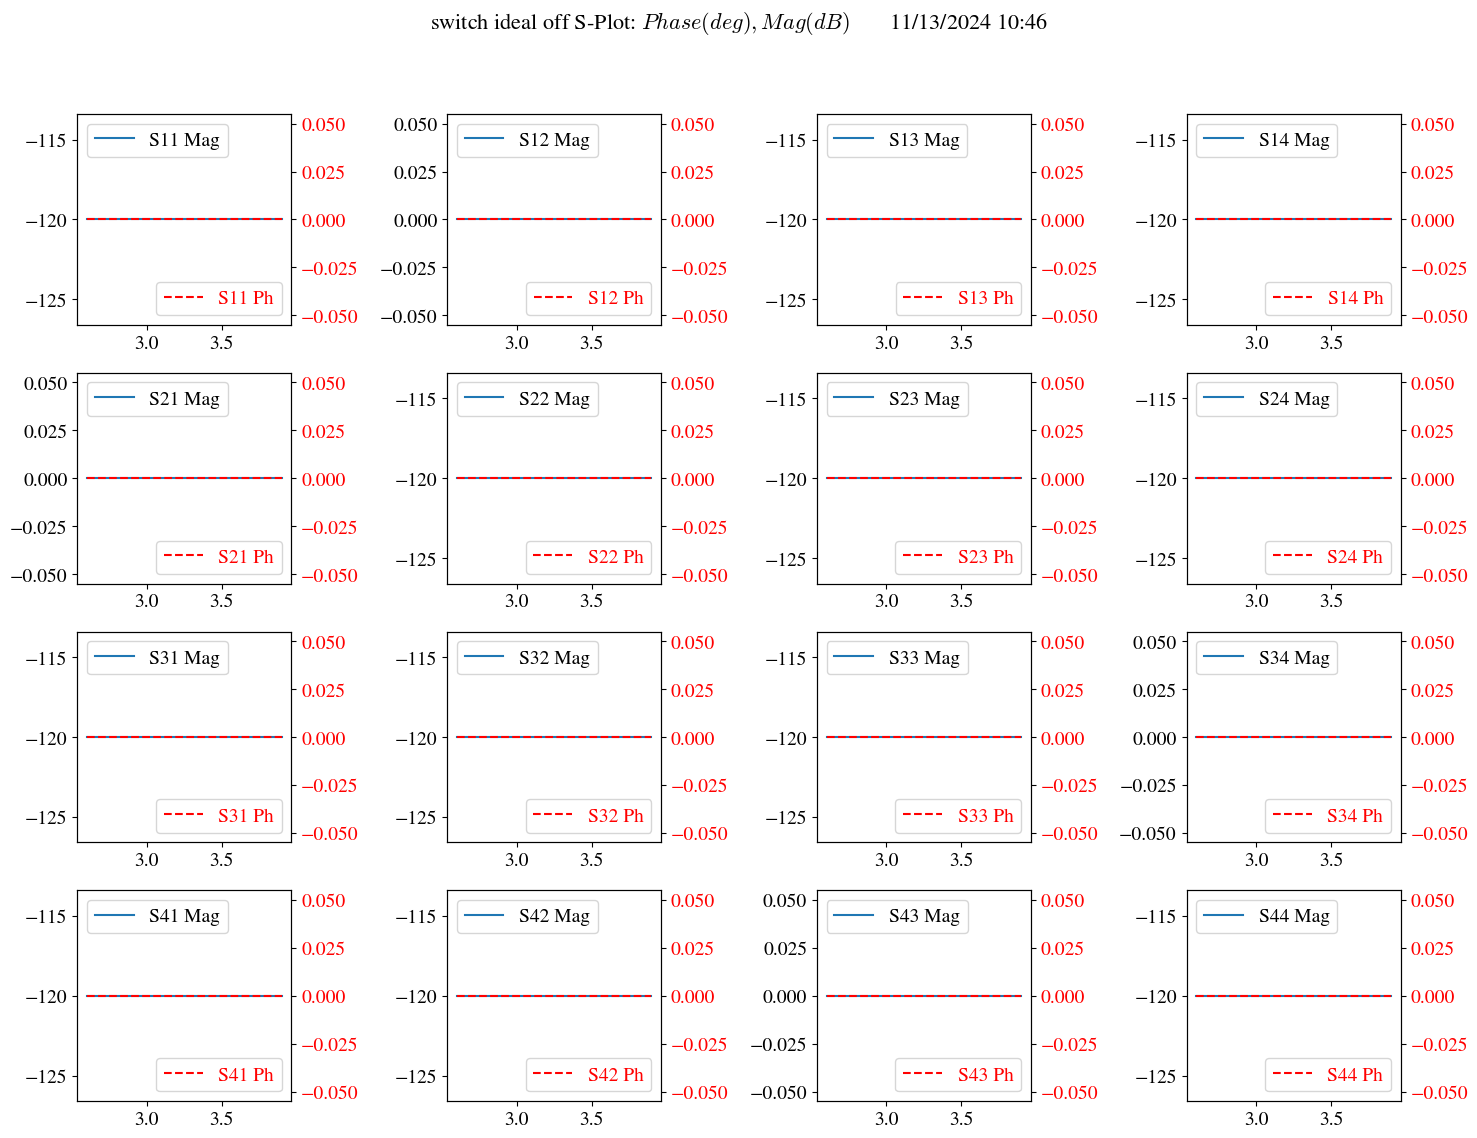

In [46]:
_ = s_plotter('switch ideal off', 'all', True, apsera_freq, 'GHz', switch_ideal_off, 4, None)

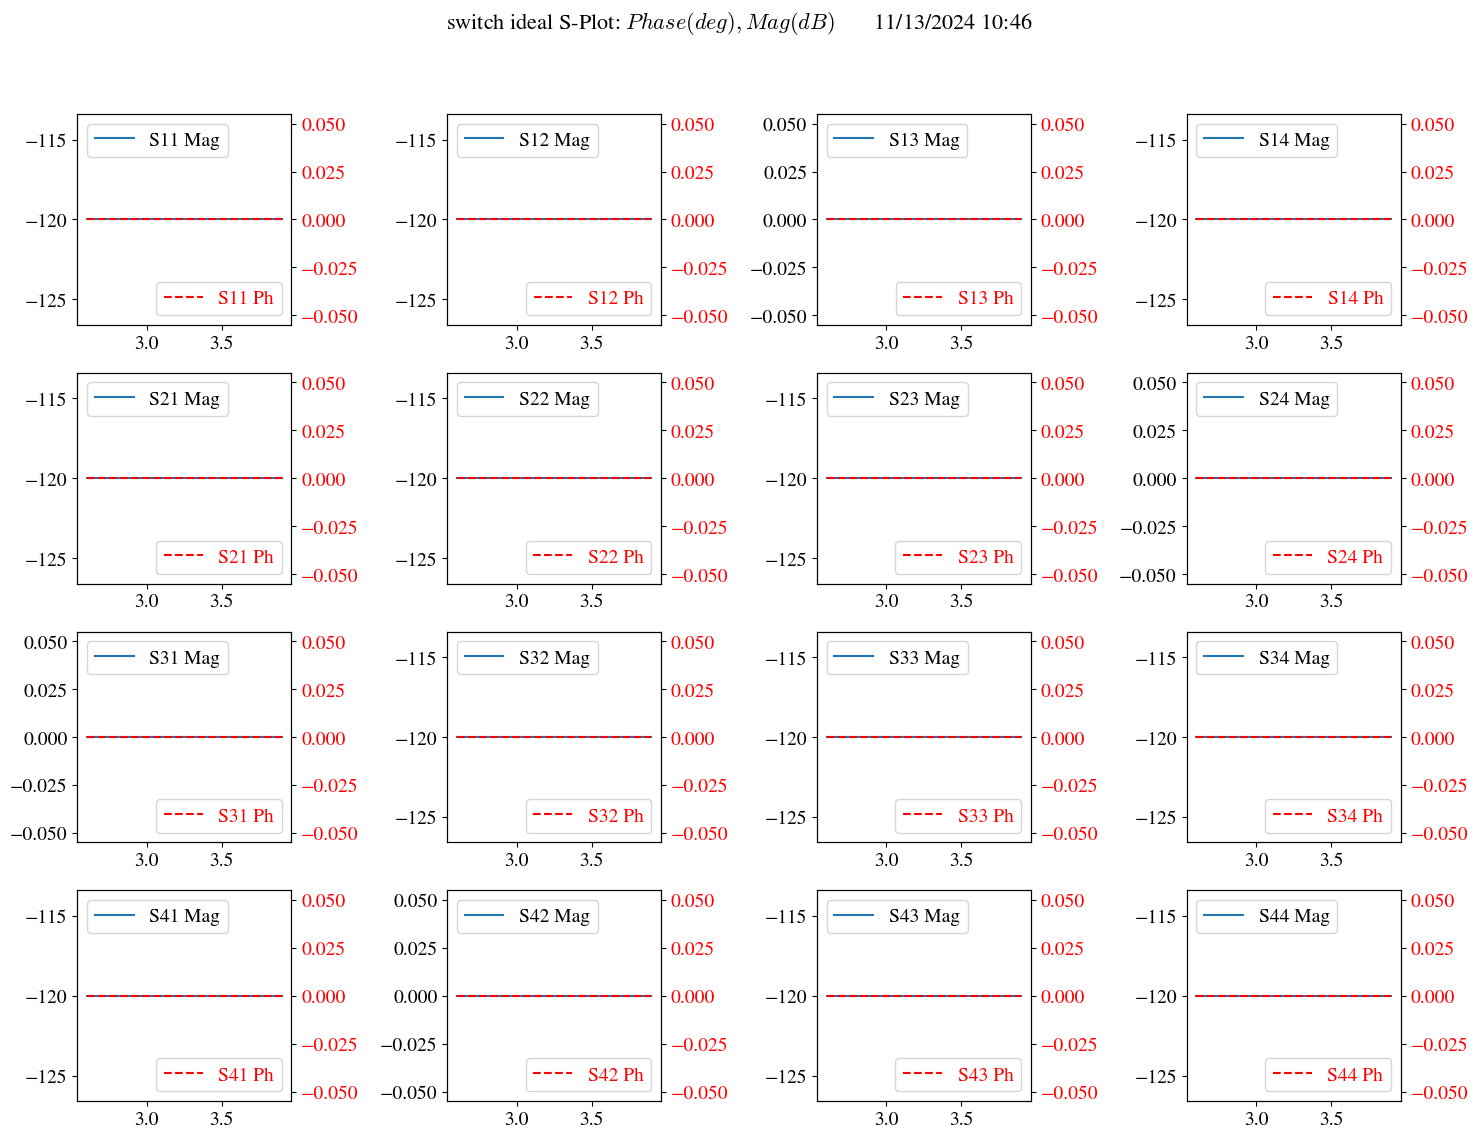

In [47]:
_ = s_plotter('switch ideal', 'all', True, apsera_freq, 'GHz', switch_ideal_on, 4, None)

c:\Work\RRI CMB\4_Hybrid_coupler_modelling\RPA\sparam.py:175: RuntimeWarning: divide by zero encountered in log10
  s_magnitudes = 20 * np.log10(np.abs(s_values))


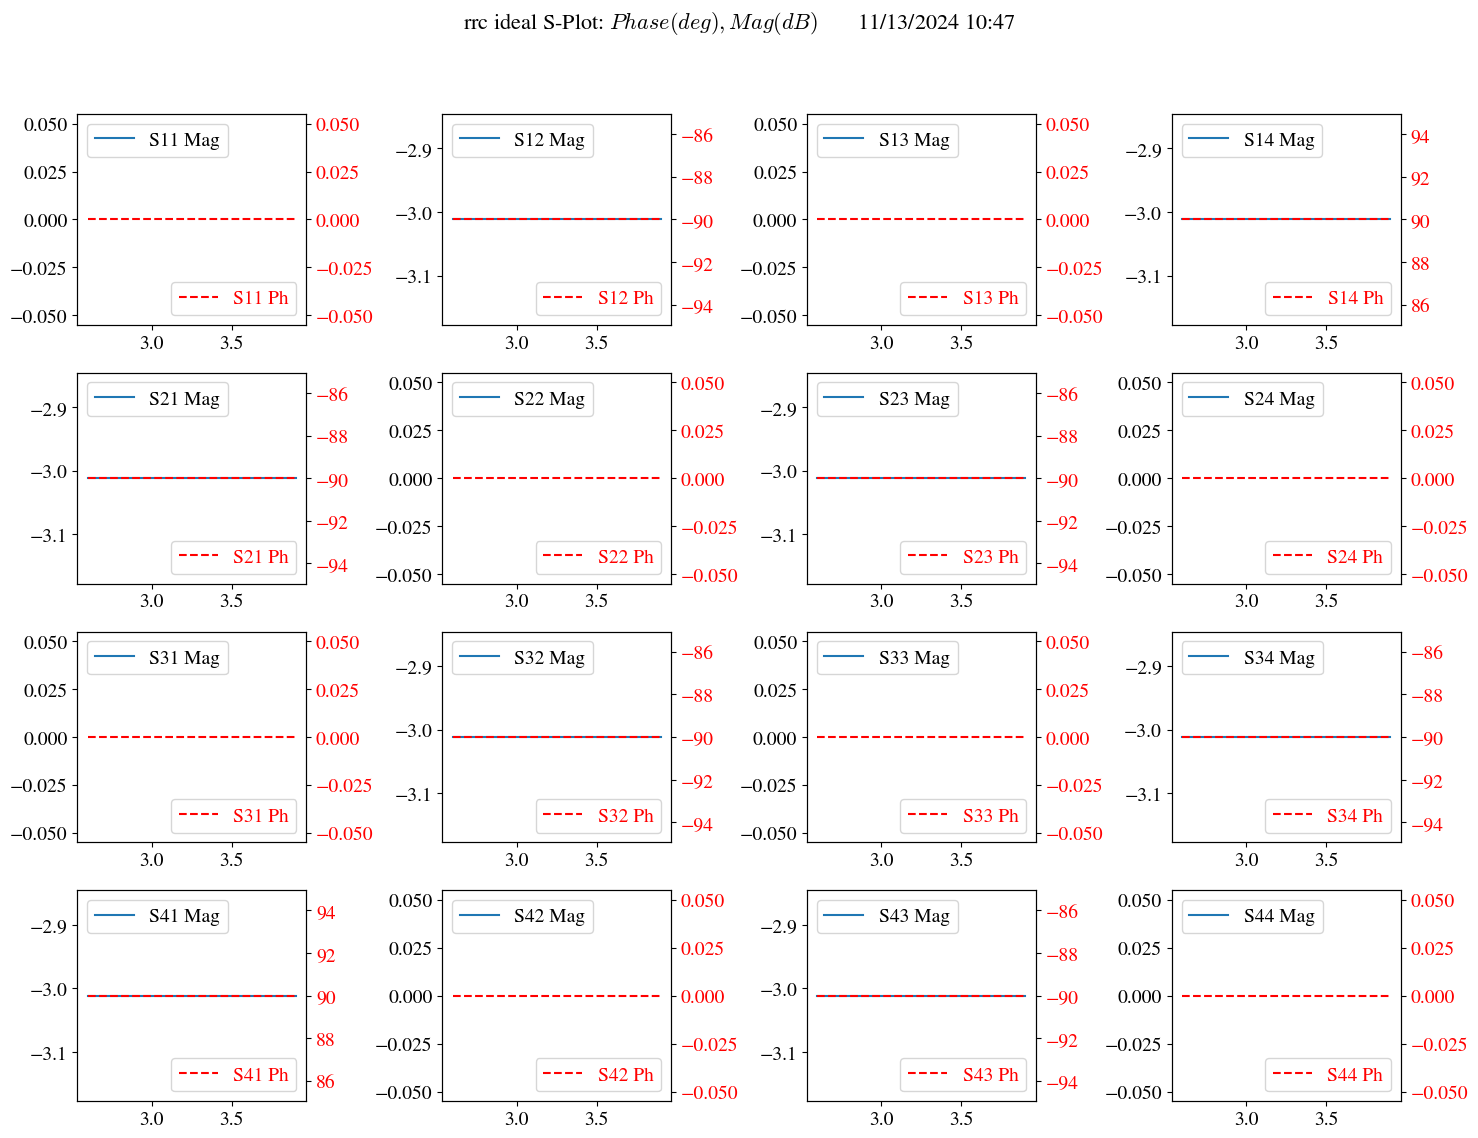

In [48]:
_ = s_plotter('rrc ideal', 'all', True, apsera_freq, 'GHz', rrc_ideal, 4, None)

# Feed the pipeline

#### Amplify antenna signal

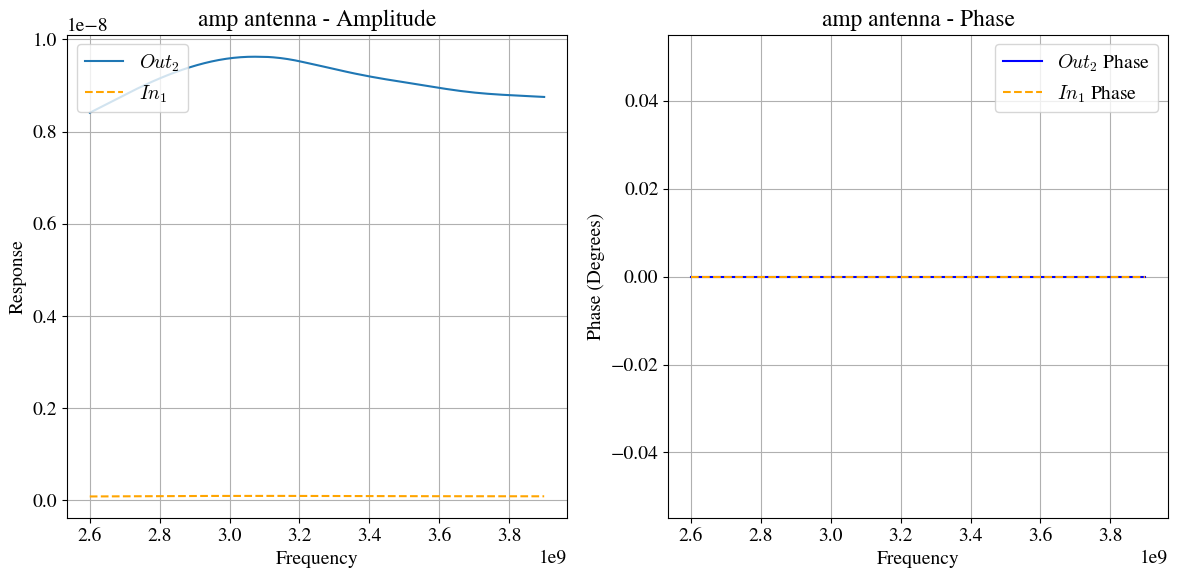

In [49]:
_, V_nu_amp = chain2ports(
    title='amp antenna', 
    devices_sparam_list=[amp_ideal_40], 
    input1=V_nu, 
    freq_=apsera_freq    )

# Ideal T_ext extraction with RPA

## Get Tobs ideal

### $T_{A}$, 300K ---> On, Ideal 

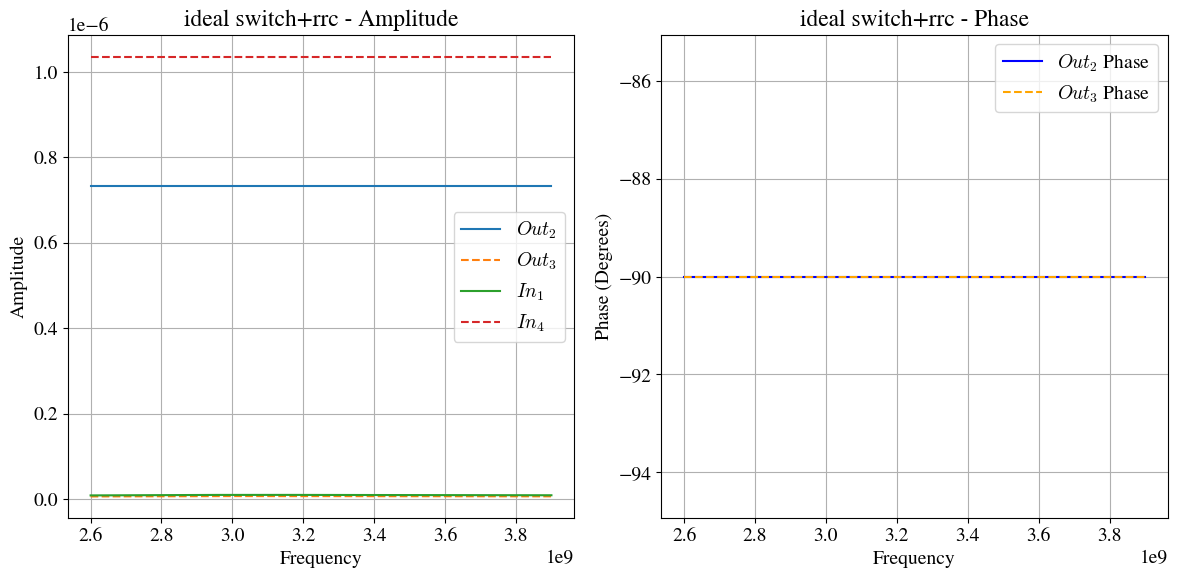

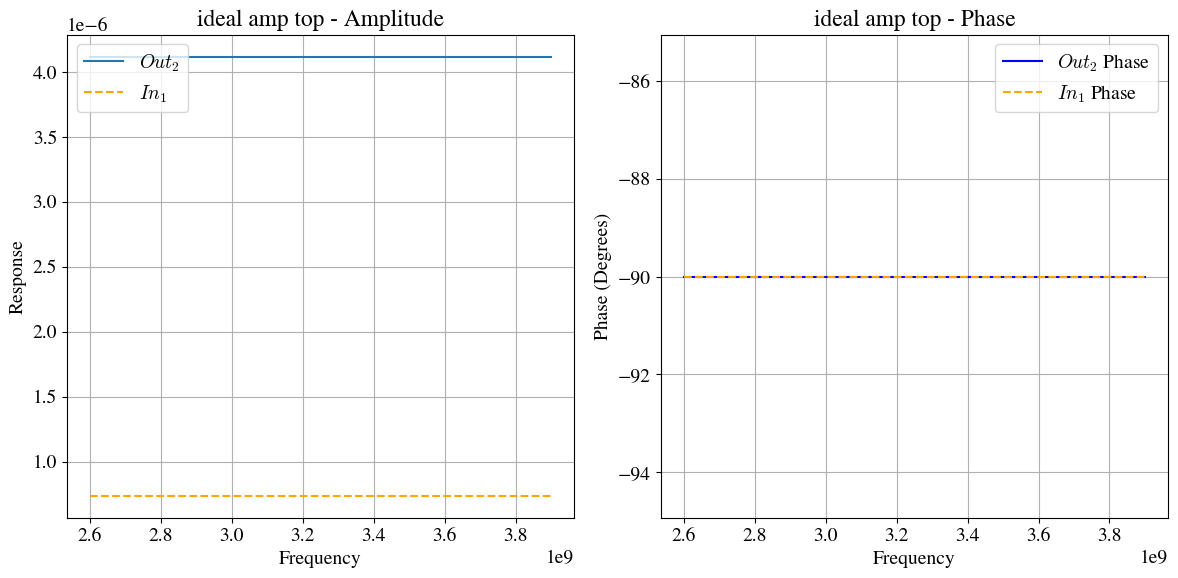

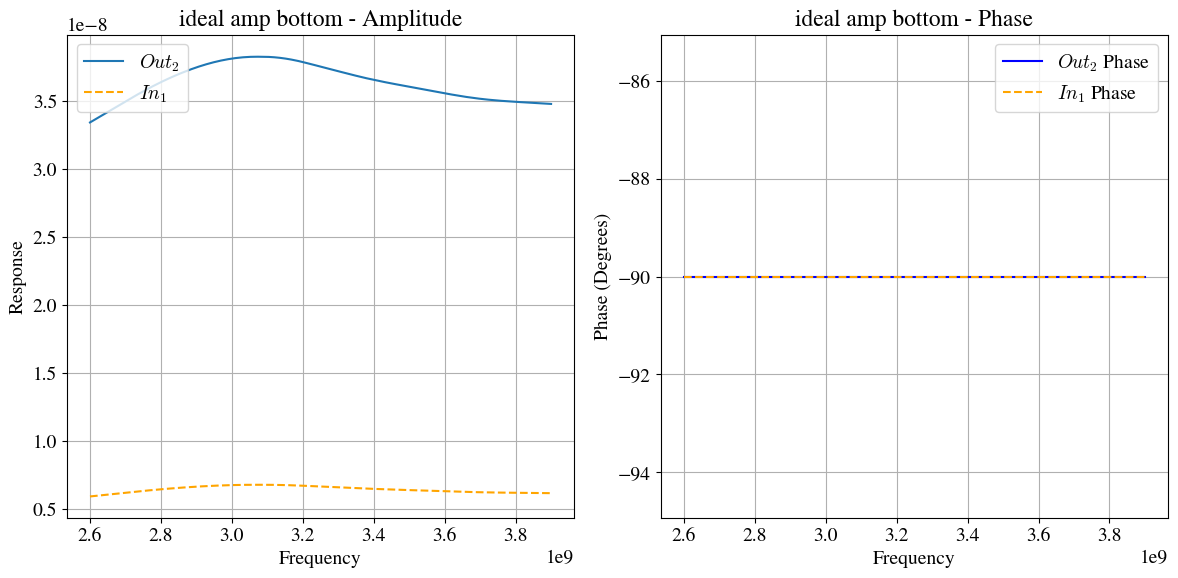

In [54]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_ideal, b3_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_on, rrc_ideal], 
    input1=V_nu_amp, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]     )

_, b2_top_ideal_on = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_ideal, 
    freq_=apsera_freq    )

_, b2_bottom_ideal_on = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_ideal, 
    freq_=apsera_freq    )

### Correlate

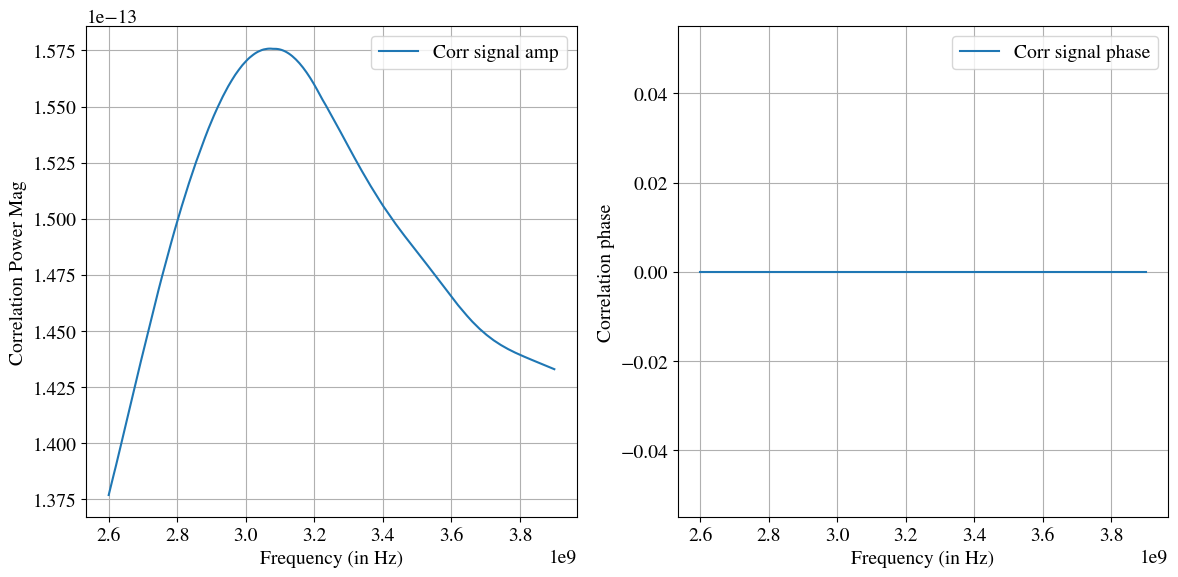

In [55]:
#correlate the output
fig_corr_ideal, t_obs01 = correlator(input1=b2_top_ideal_on, input2=b2_bottom_ideal_on, x=apsera_freq)  #t_obs01

### $T_{A}$, 300K ---> Off, Ideal 

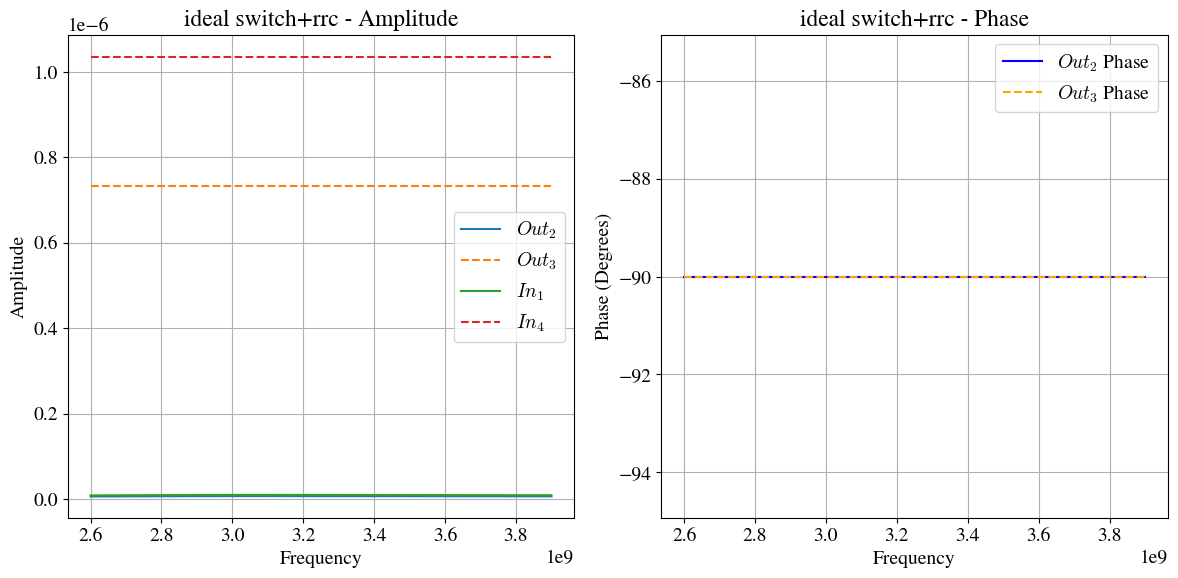

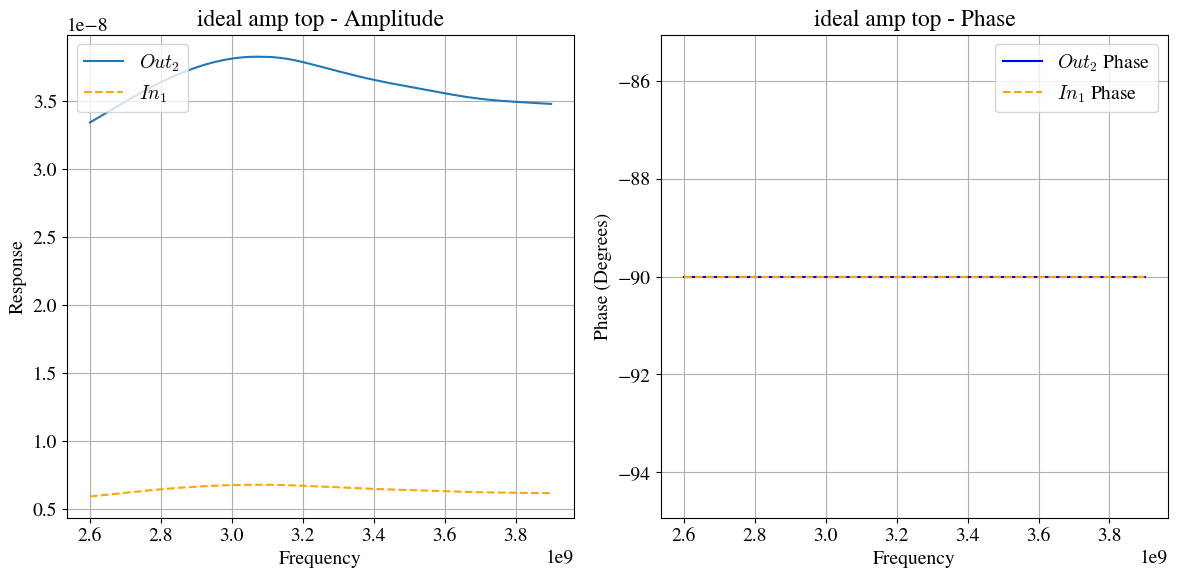

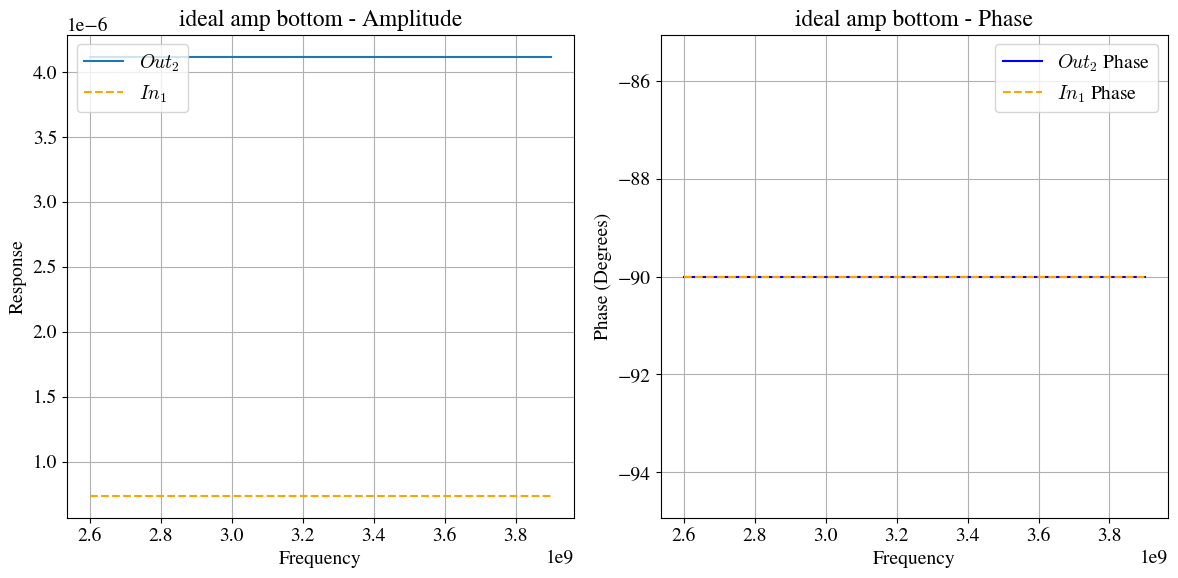

In [56]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_ideal, b3_rrc_ideal = chain4ports(
    title='ideal switch+rrc', 
    devices_sparam_list=[switch_ideal_off, rrc_ideal], 
    input1=V_nu_amp, 
    input2= noise_300 ,#noise_300   [0]*len(apsera_freq)
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]       )

_, b2_top_ideal_off = chain2ports(
    title='ideal amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_ideal, 
    freq_=apsera_freq    )

_, b2_bottom_ideal_off = chain2ports(
    title='ideal amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_ideal, 
    freq_=apsera_freq    )

### Correlate

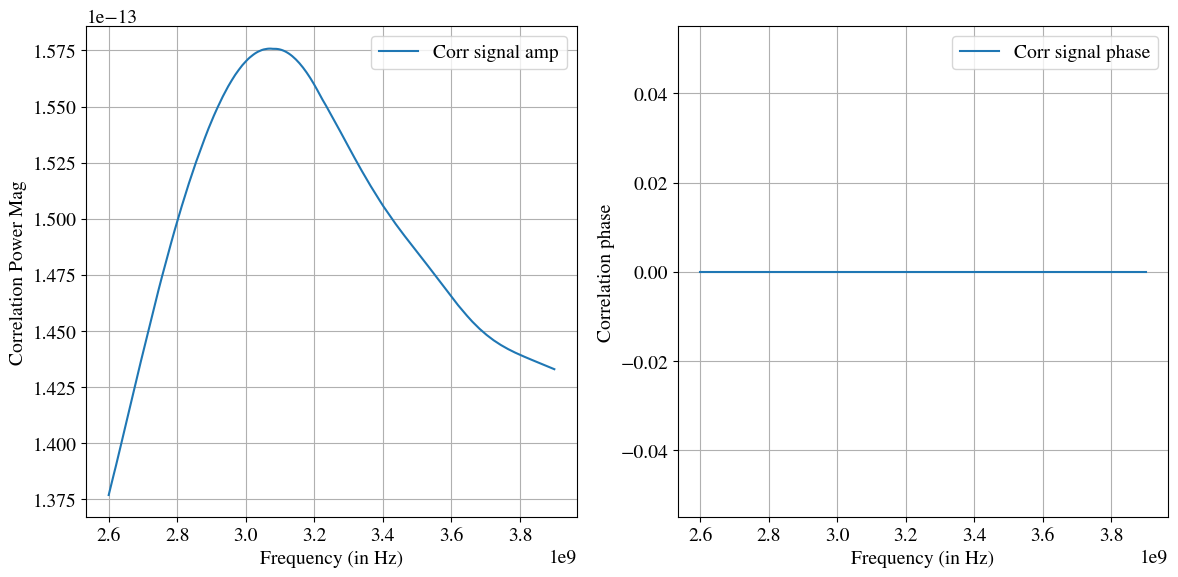

In [57]:
#correlate the output
fig_corr_ideal, t_obs00 = correlator(input1=b2_top_ideal_off, input2=b2_bottom_ideal_off, x=apsera_freq)

### Get Tobs ideal

3.390660913465451e-11 180.0


C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


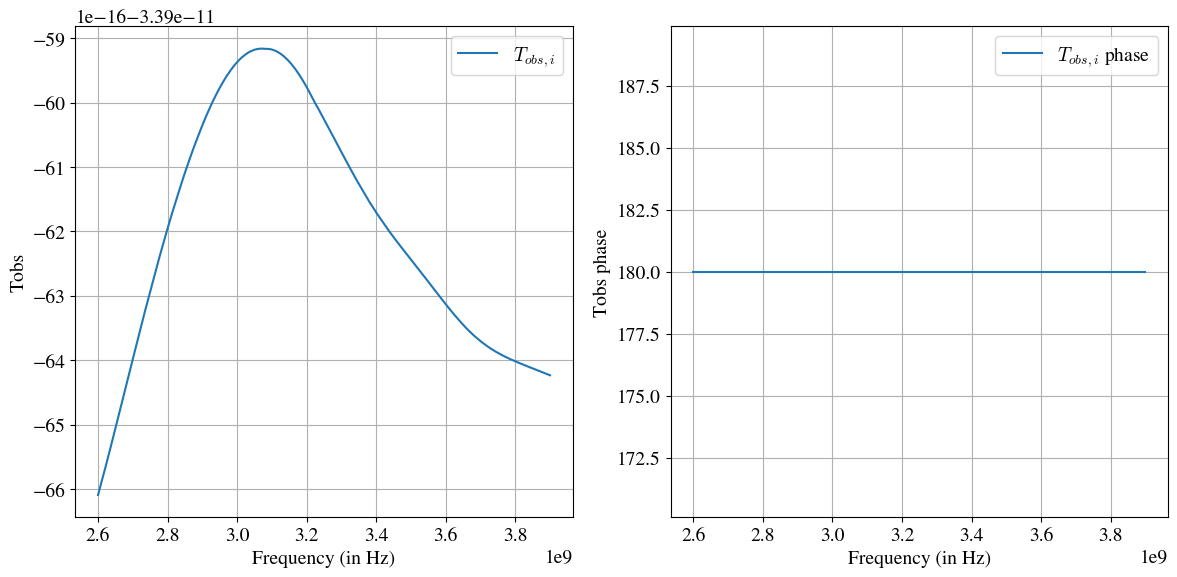

In [23]:
Tobs_ideal = t_obs00 - t_obs01   #  through (on) - crossed (off)
print(np.abs(Tobs_ideal[0]), np.angle(Tobs_ideal[0], deg=True))
# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Tobs_ideal), label='$T_{obs,i}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()

# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.angle(Tobs_ideal, deg=True), label='$T_{obs,i}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
#axs[1].set_ylim(-1,1)
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Tcold ideal

### 77K, 300K ---> On, non Ideal

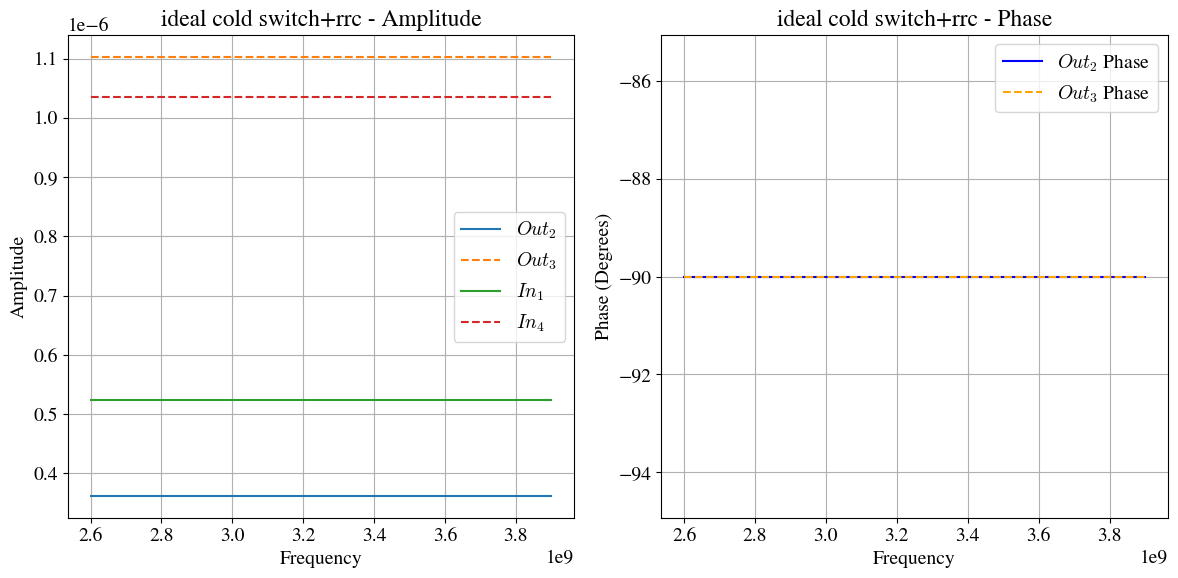

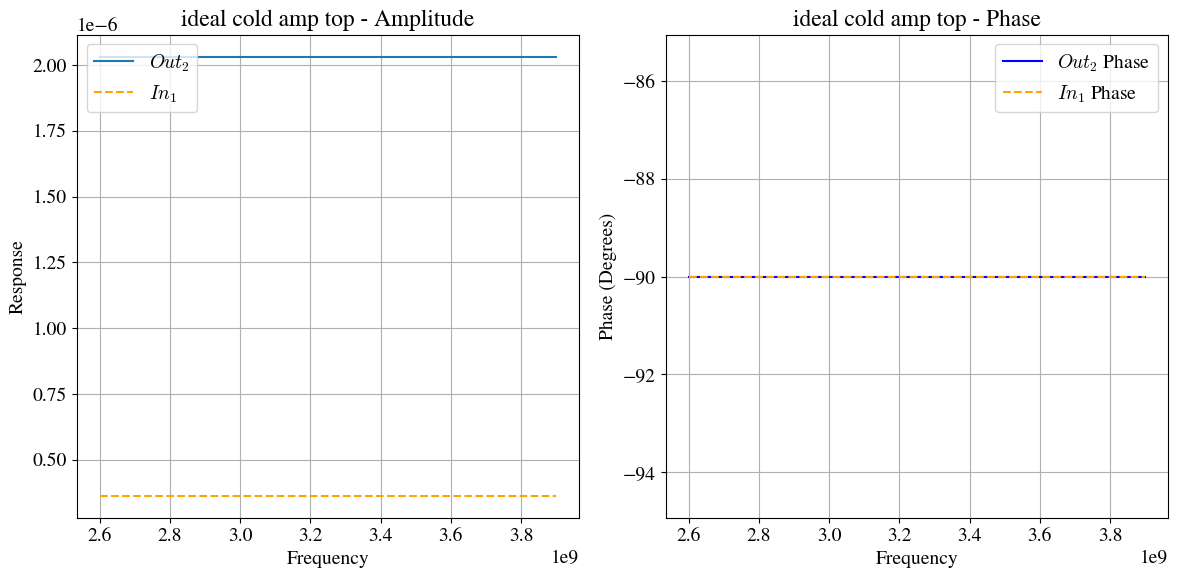

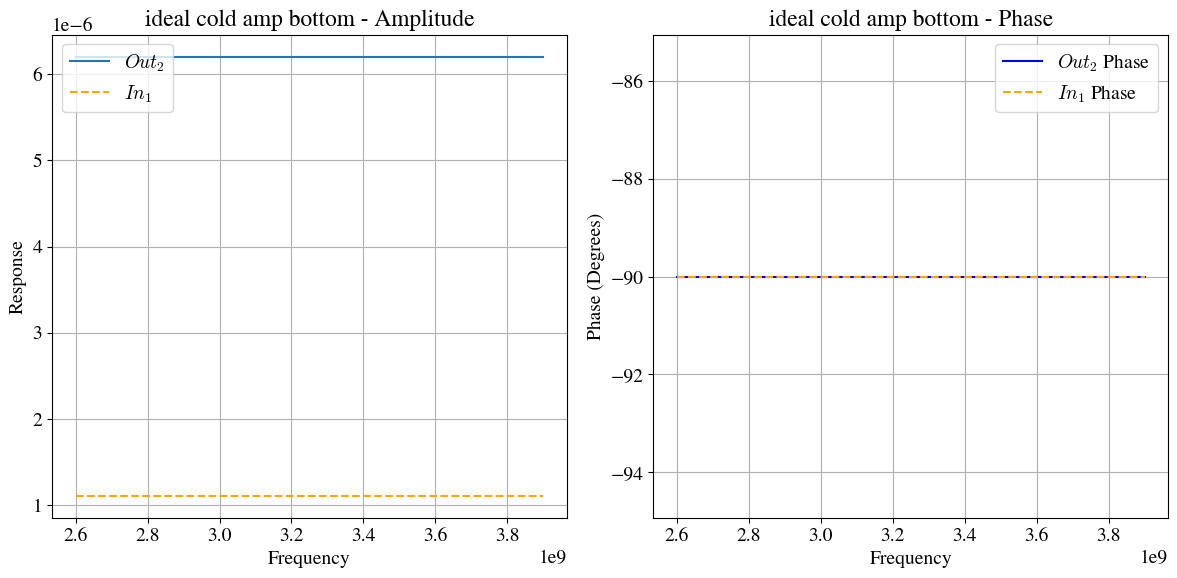

In [24]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_on_cold, b3_rrc_on_cold = chain4ports(
    title='ideal cold switch+rrc', 
    devices_sparam_list=[switch_ideal_on, rrc_ideal], 
    input1=coldload_vsd, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]     )

_, b2_top_on_cold = chain2ports(
    title='ideal cold amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_on_cold, 
    freq_=apsera_freq    )

_, b2_bottom_on_cold = chain2ports(
    title='ideal cold amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_on_cold, 
    freq_=apsera_freq    )

### Correlate

Text(0.5, 1.0, 'Switch on with inputs as 77K, 300K')

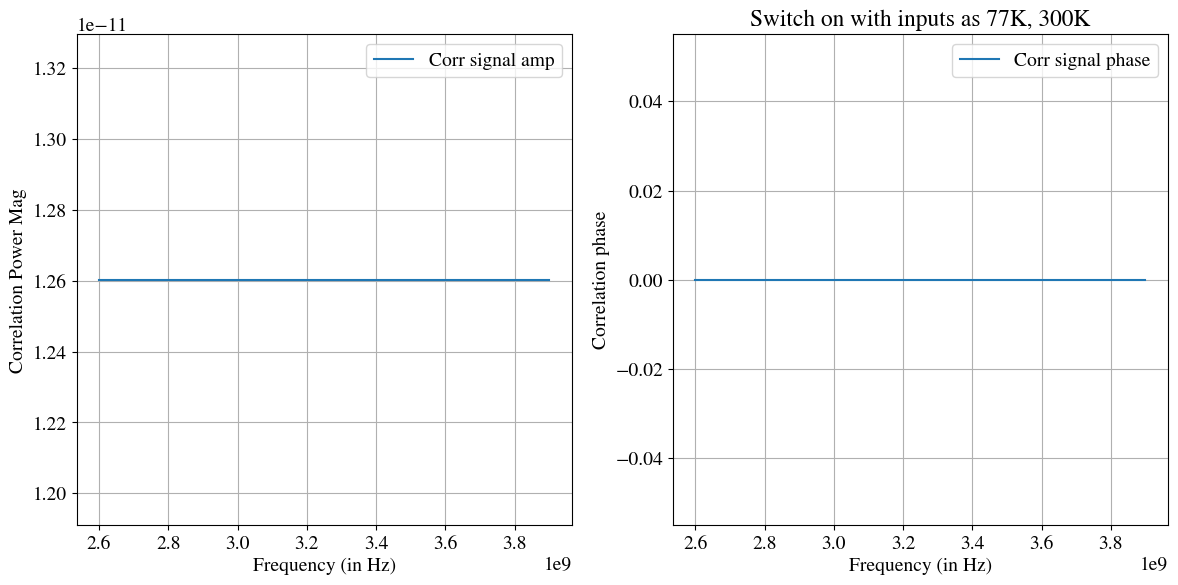

In [25]:
#correlate the output
_, Tcold01 = correlator(input1=b2_top_on_cold, input2=b2_bottom_on_cold, x=apsera_freq)
plt.title('Switch on with inputs as 77K, 300K')

### 77K, 300K ---> Switch off, non Ideal case

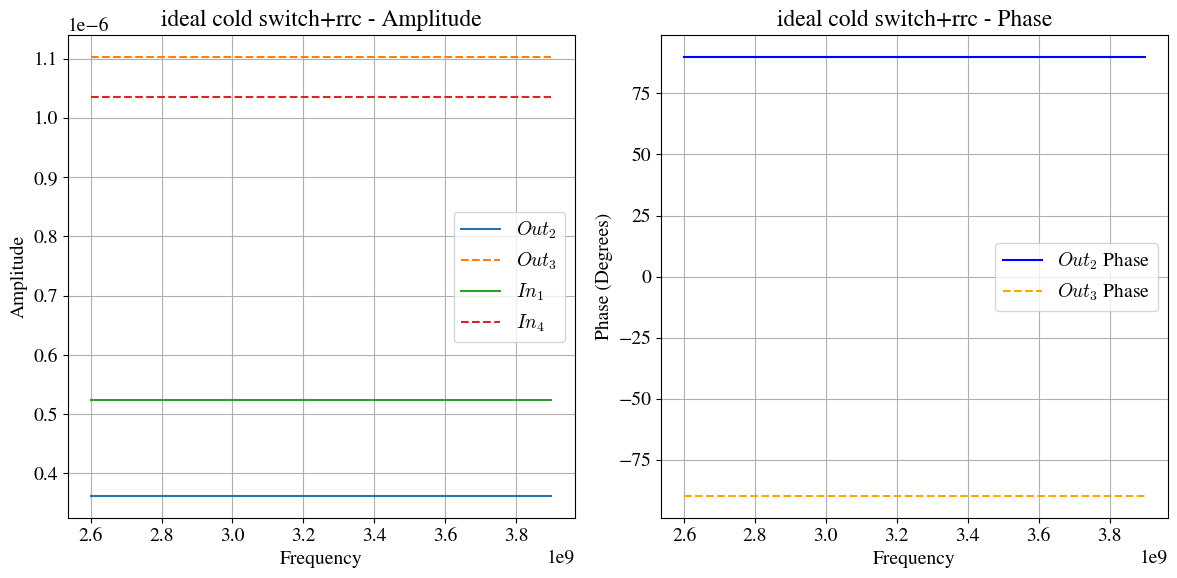

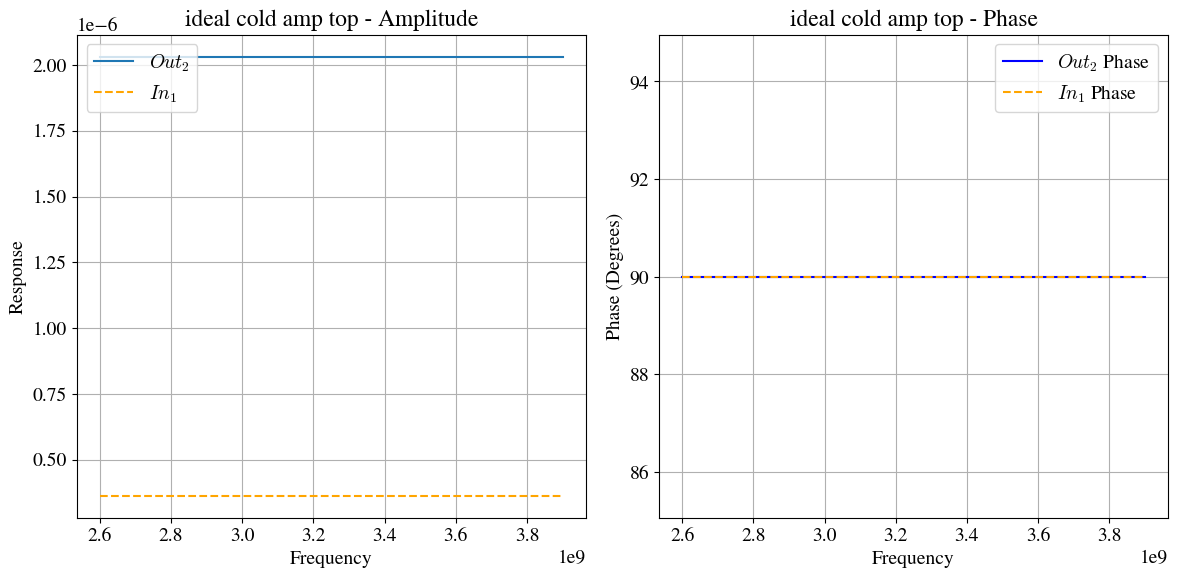

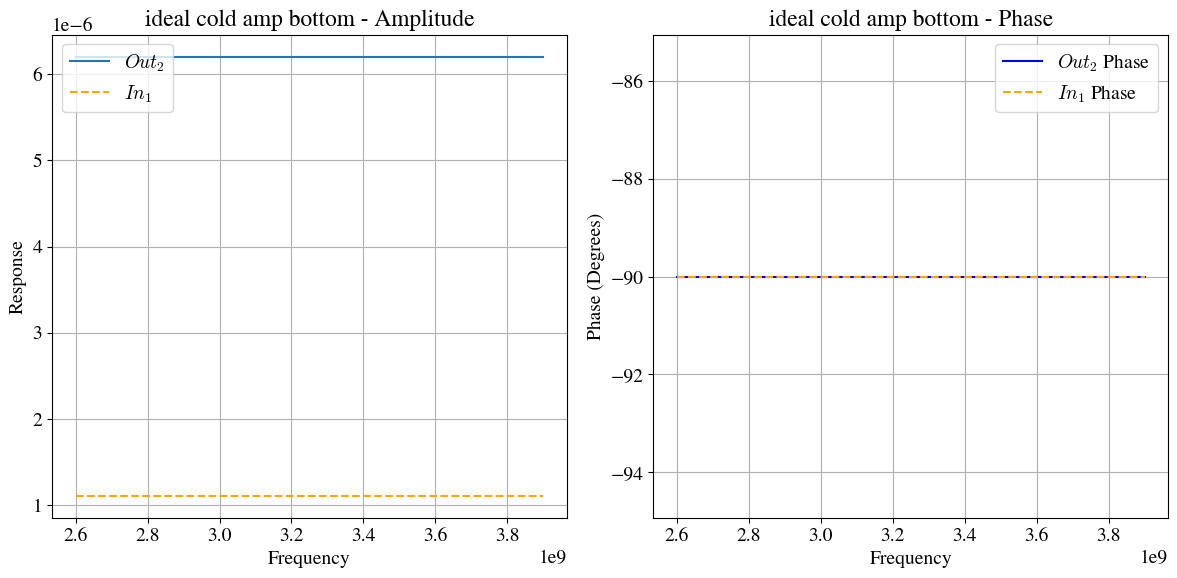

In [26]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_off_cold, b3_rrc_off_cold = chain4ports(
    title='ideal cold switch+rrc', 
    devices_sparam_list=[switch_ideal_off, rrc_ideal], 
    input1=coldload_vsd, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]     )

_, b2_top_off_cold = chain2ports(
    title='ideal cold amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_off_cold, 
    freq_=apsera_freq    )

_, b2_bottom_off_cold = chain2ports(
    title='ideal cold amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_off_cold, 
    freq_=apsera_freq    )

### Correlate

Text(0.5, 1.0, 'Switch off with inputs as 77K, 300K')

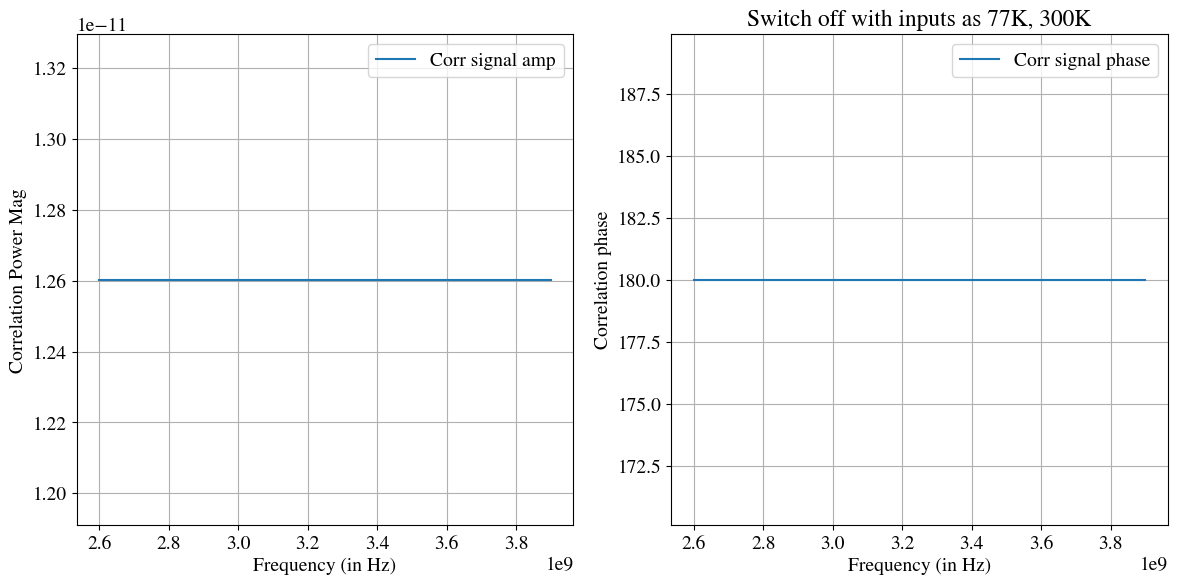

In [27]:
#correlate the output
_, Tcold00 = correlator(input1=b2_top_off_cold, input2=b2_bottom_off_cold, x=apsera_freq)
plt.title('Switch off with inputs as 77K, 300K')

### Get Tcold ideal

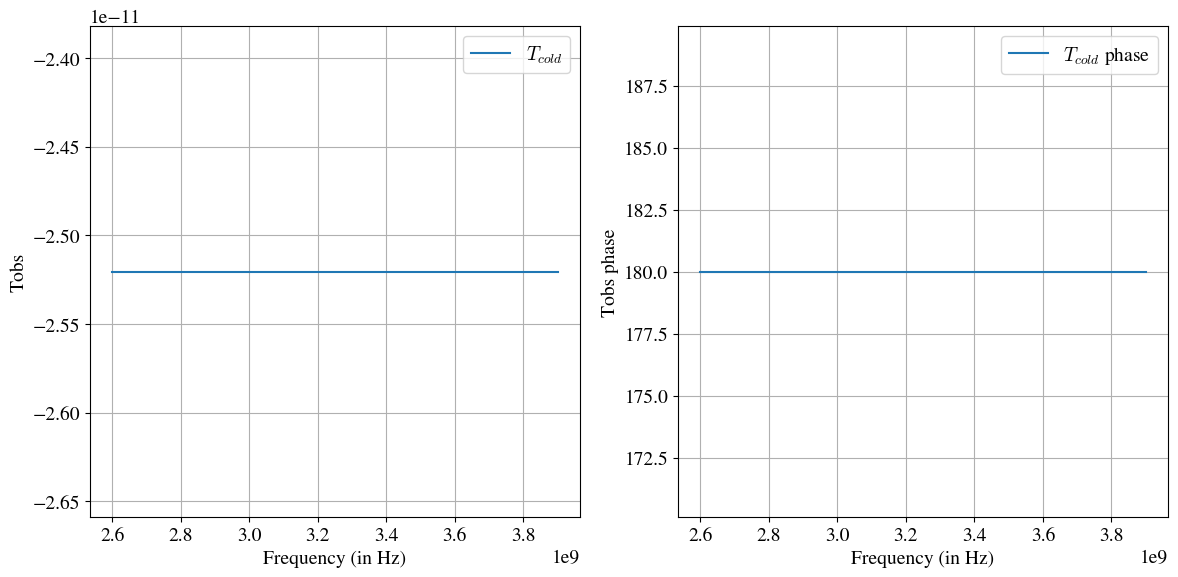

In [28]:
Tcold = Tcold00 - Tcold01

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Tcold), label='$T_{cold}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()


# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.angle(Tcold, deg=True), label='$T_{cold}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Thot ideal

### 315K, 300K ---> Switch on, non Ideal case

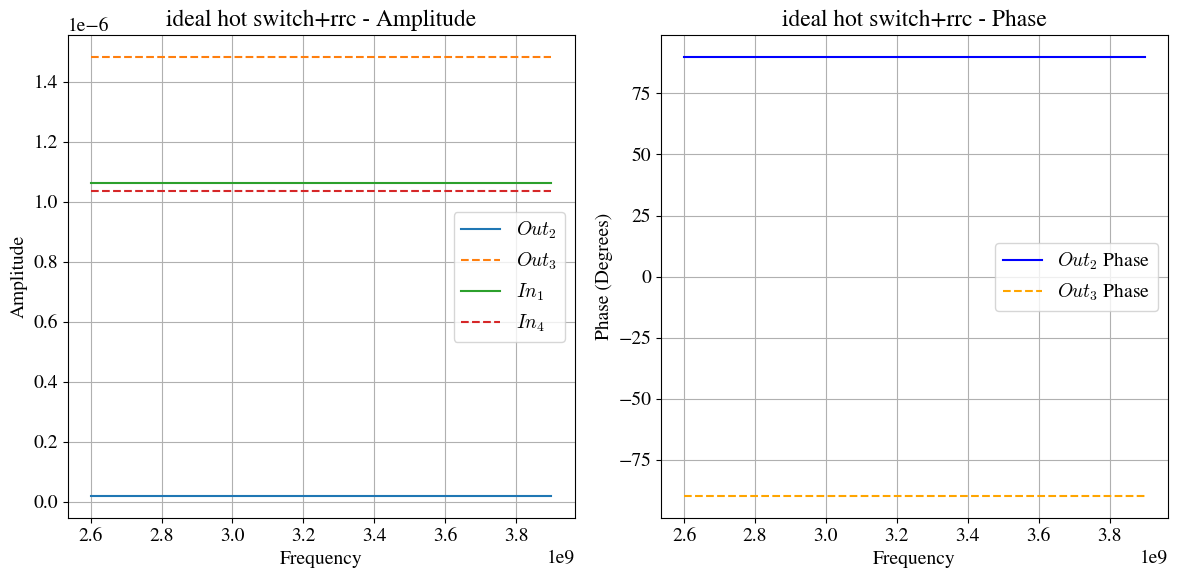

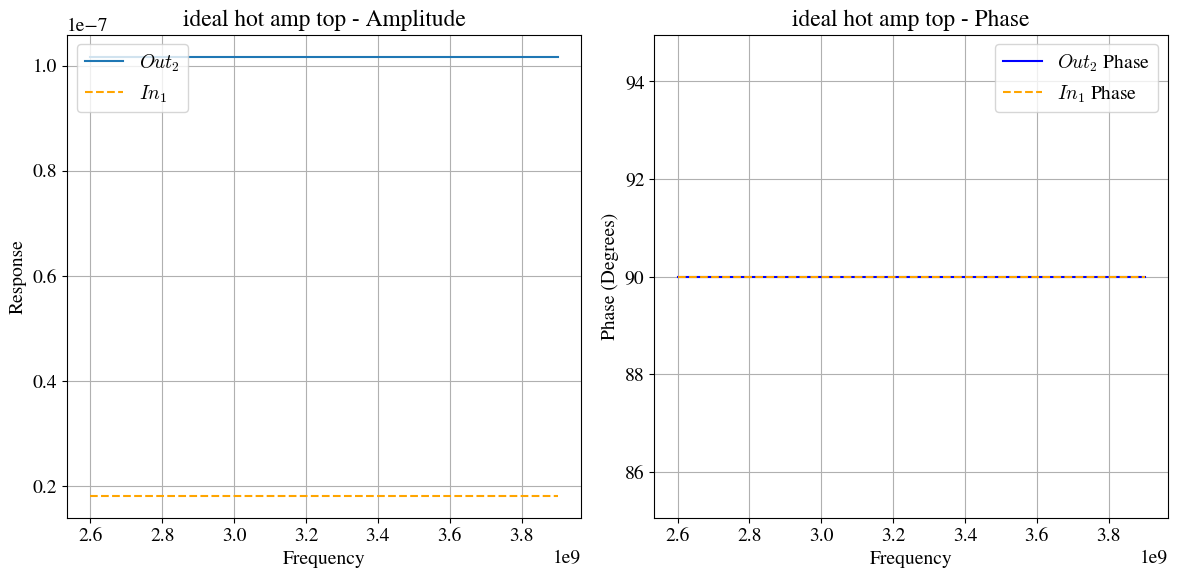

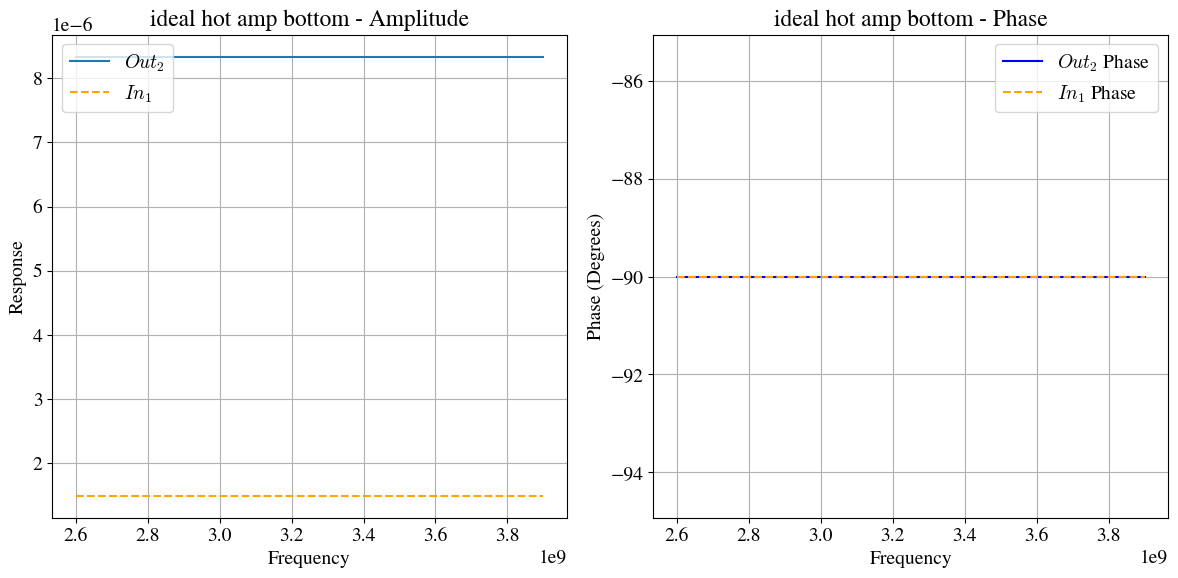

In [29]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_on_hot, b3_rrc_on_hot = chain4ports(
    title='ideal hot switch+rrc', 
    devices_sparam_list=[switch_ideal_on, rrc_ideal], 
    input1=hotload_vsd, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]     )

_, b2_top_on_hot = chain2ports(
    title='ideal hot amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_on_hot, 
    freq_=apsera_freq    )

_, b2_bottom_on_hot = chain2ports(
    title='ideal hot amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_on_hot, 
    freq_=apsera_freq    )

### Correlate

Text(0.5, 1.0, 'Switch on with inputs as 315K, 300K')

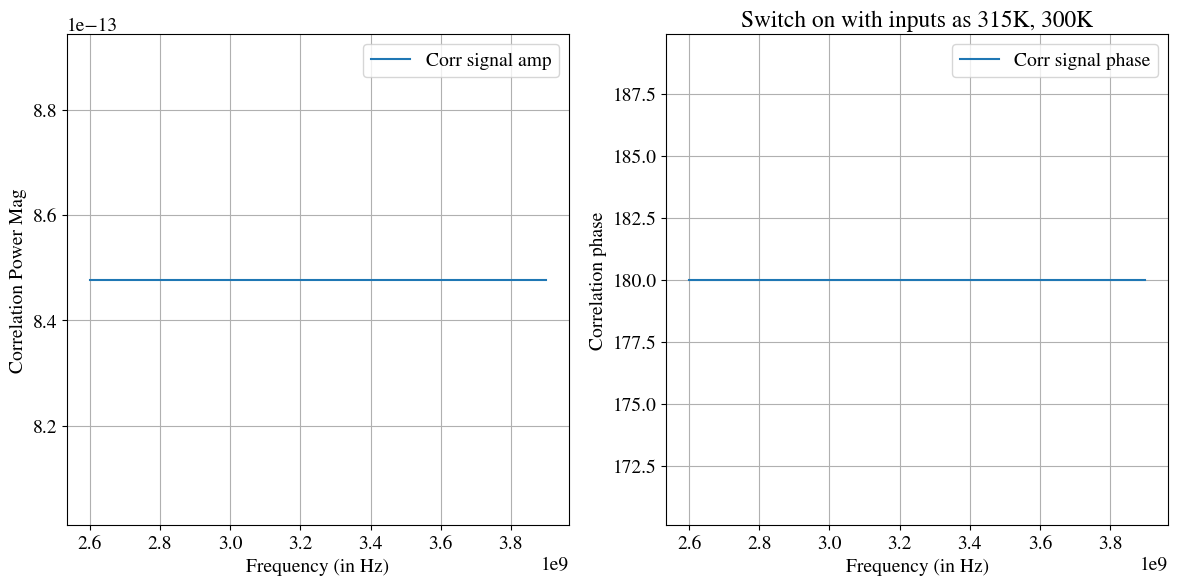

In [30]:
#correlate the output
_, Thot01 = correlator(input1=b2_top_on_hot, input2=b2_bottom_on_hot, x=apsera_freq)
plt.title('Switch on with inputs as 315K, 300K')

### 315K, 300K ---> Switch off, non Ideal case

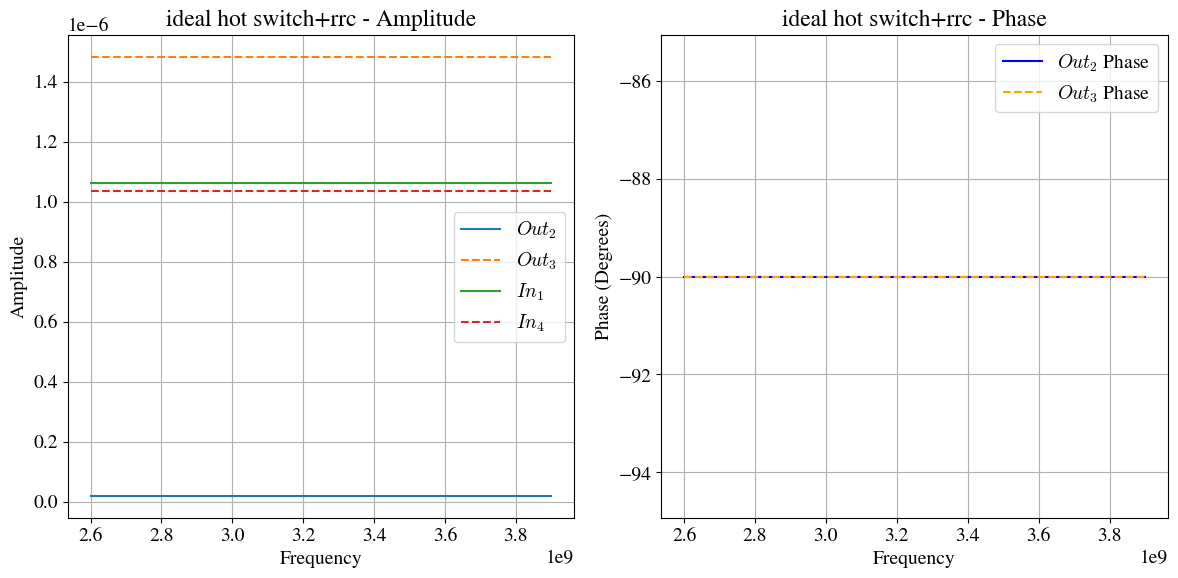

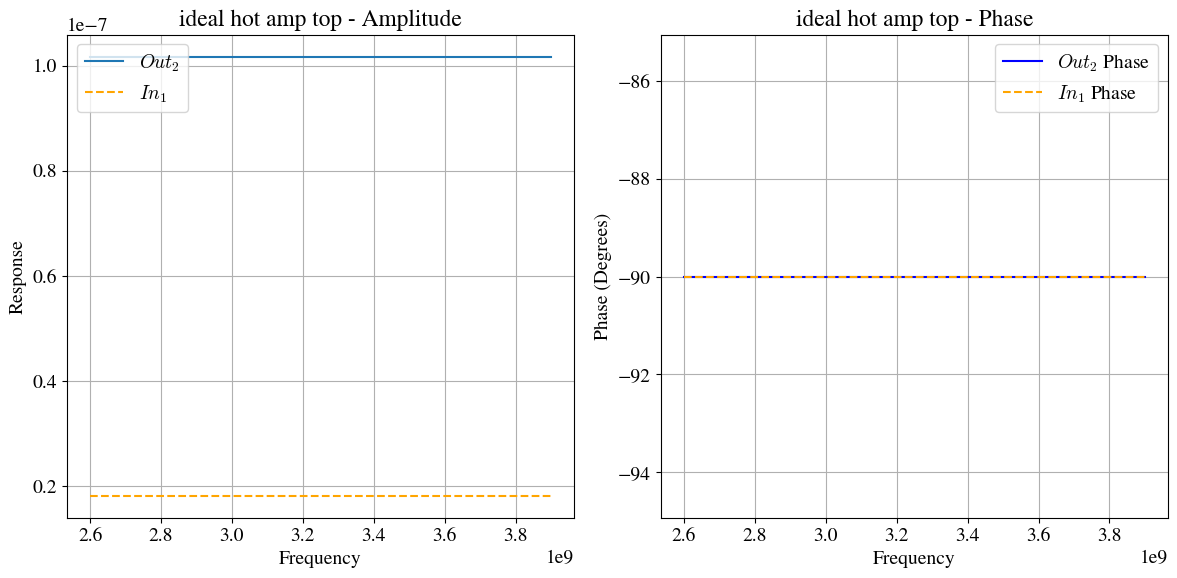

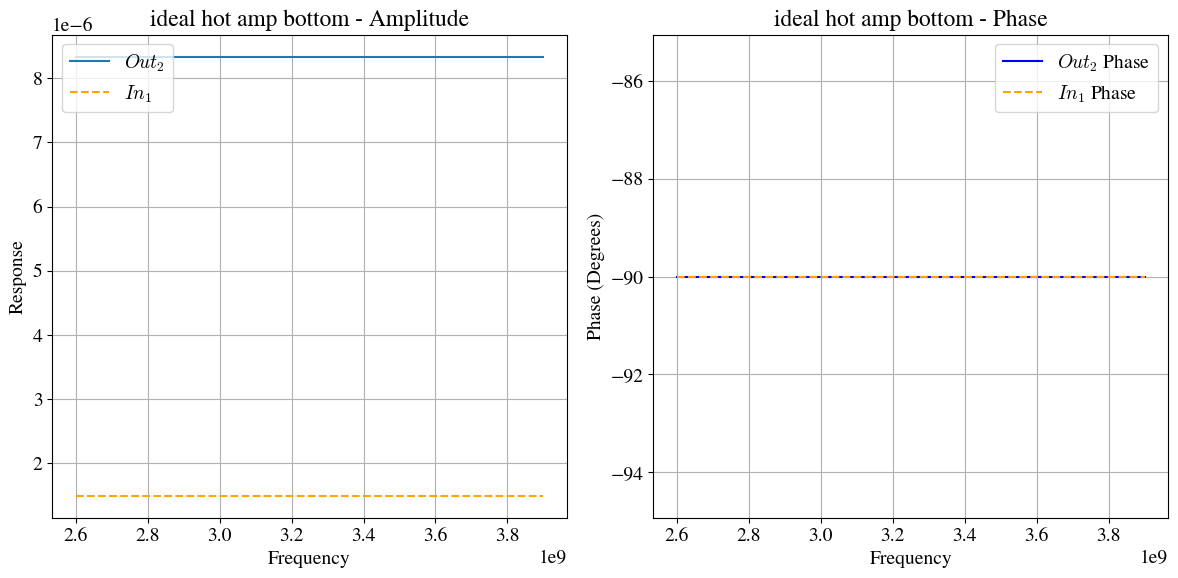

In [31]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
_, b2_rrc_off_hot, b3_rrc_off_hot = chain4ports(
    title='ideal hot switch+rrc', 
    devices_sparam_list=[switch_ideal_off, rrc_ideal], 
    input1=hotload_vsd, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq,
    flipinput=[0,0]     )

_, b2_top_off_hot = chain2ports(
    title='ideal hot amp top', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b2_rrc_off_hot, 
    freq_=apsera_freq    )

_, b2_bottom_off_hot = chain2ports(
    title='ideal hot amp bottom', 
    devices_sparam_list=[amp_ideal_15], 
    input1=b3_rrc_off_hot, 
    freq_=apsera_freq    )

### Correlate

Text(0.5, 1.0, 'Switch on with inputs as 315K, 300K')

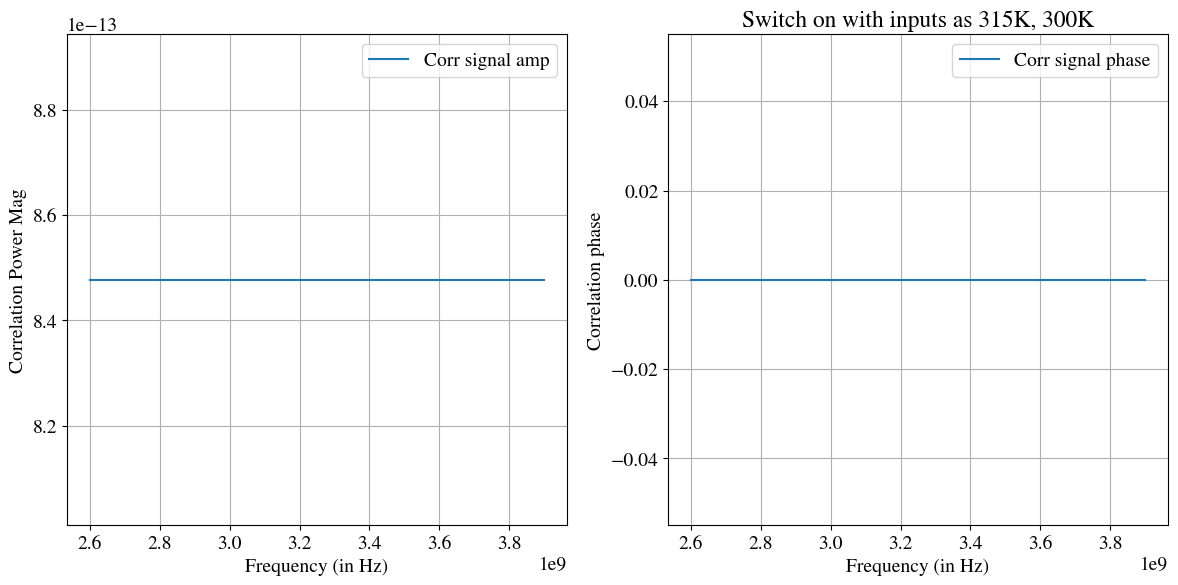

In [32]:
#correlate the output
_, Thot00 = correlator(input1=b2_top_off_hot, input2=b2_bottom_off_hot, x=apsera_freq)
plt.title('Switch on with inputs as 315K, 300K')

### Get Thot ideal

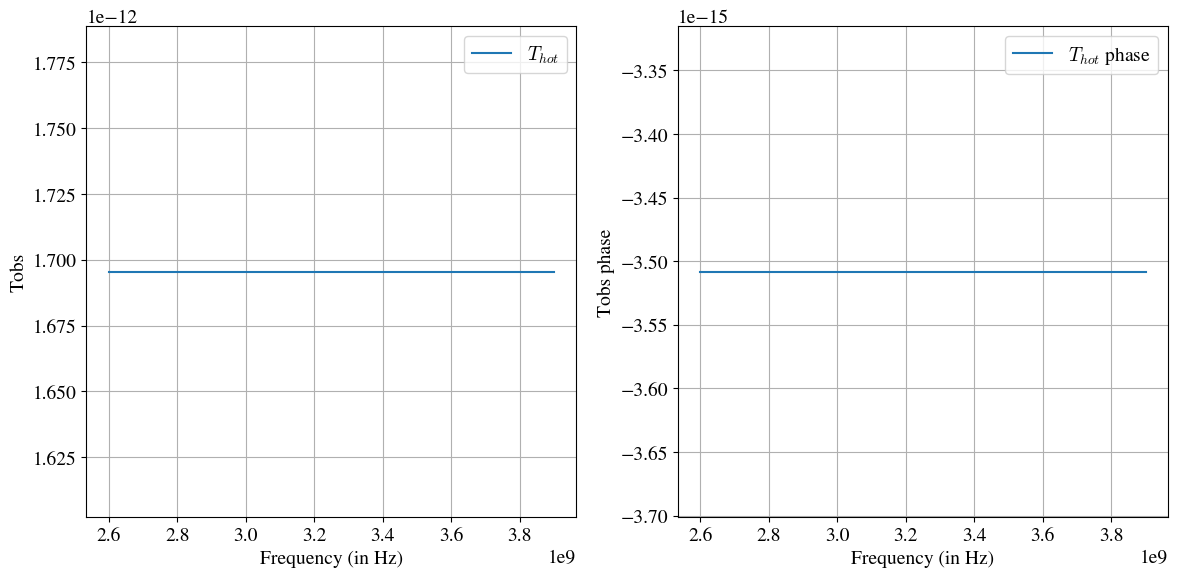

In [33]:
Thot = Thot00 - Thot01

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Thot), label='$T_{hot}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()

# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.degrees(np.angle(Thot)), label='$T_{hot}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()

## Get Text ideal

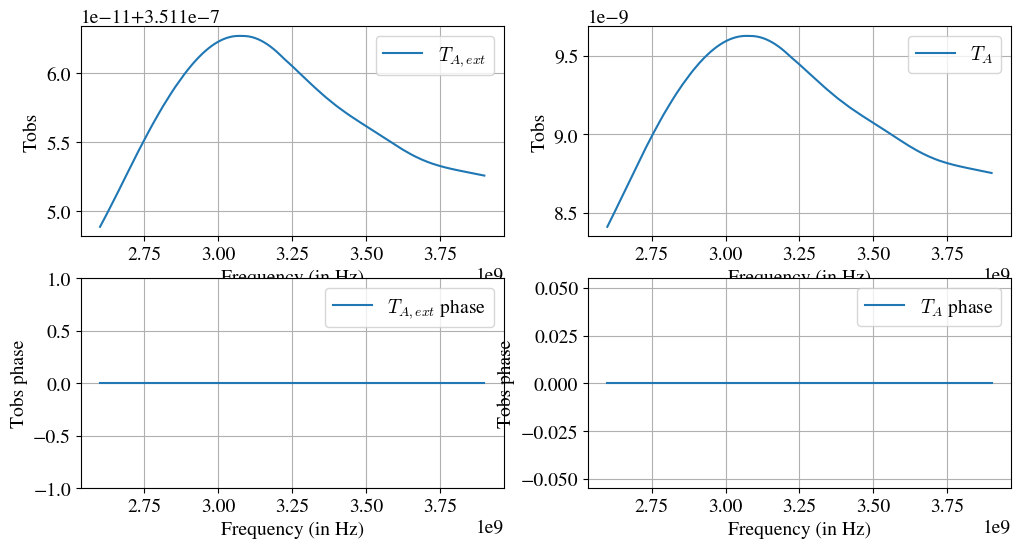

In [34]:
T_a_reflected = ((Tobs_ideal - Tcold) * (hotload_vsd-coldload_vsd))/(Thot-Tcold) + coldload_vsd
# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0][0].plot(apsera_freq, np.abs(T_a_reflected), label='$T_{A,ext}$')
#axs[0].plot(apsera_freq, np.abs(V_nu_amp), label='$T_{A}$')
axs[0][0].set_ylabel('Tobs')
axs[0][0].set_xlabel('Frequency (in Hz)')
axs[0][0].grid()
axs[0][0].legend()

# second plot: Correlation amplitude
axs[0][1].plot(apsera_freq, np.abs(V_nu_amp), label='$T_{A}$')
axs[0][1].set_ylabel('Tobs')
axs[0][1].set_xlabel('Frequency (in Hz)')
axs[0][1].grid()
axs[0][1].legend()

# Third plot: Correlation phase
axs[1][0].plot(apsera_freq, np.angle(T_a_reflected, deg=True), label='$T_{A,ext}$ phase')
axs[1][0].set_ylabel('Tobs phase')
axs[1][0].set_xlabel('Frequency (in Hz)')
axs[1][0].grid()
axs[1][0].set_ylim(-1,1)
axs[1][0].legend()

# Fourth plot: Correlation phase
axs[1][1].plot(apsera_freq, np.angle(V_nu_amp, deg=True), label='$T_{A}$ phase')
axs[1][1].set_ylabel('Tobs phase')
axs[1][1].set_xlabel('Frequency (in Hz)')
axs[1][1].grid()
axs[1][1].legend()

# Non-Ideal T_ext extraction with RPA

## Get Tobs non ideal

### T_obs, 300K ---> On, non-ideal

In [35]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
fig_switch_rrc, b2_rrc, b3_rrc = chain4ports(
    title='switch+rrc', 
    devices_sparam_list=[switch_on, rrc], 
    input1= V_nu_amp,
    input2= noise_300,
    cross_input=[0,0], 
    freq_=apsera_freq     )

fig_amptop, b2_top = chain2ports(
    title='amp top', 
    devices_sparam_list=[amp], 
    input1=b2_rrc, 
    freq_=apsera_freq    )

fig_ampbottom, b2_bottom = chain2ports(
    title='amp bottom', 
    devices_sparam_list=[amp], 
    input1=b3_rrc, 
    freq_=apsera_freq    )

TypeError: chain4ports() missing 1 required positional argument: 'flipinput'

### Correlate

Text(0.5, 1.0, 'Switch on with inputs as $T_{A}$, 300K')

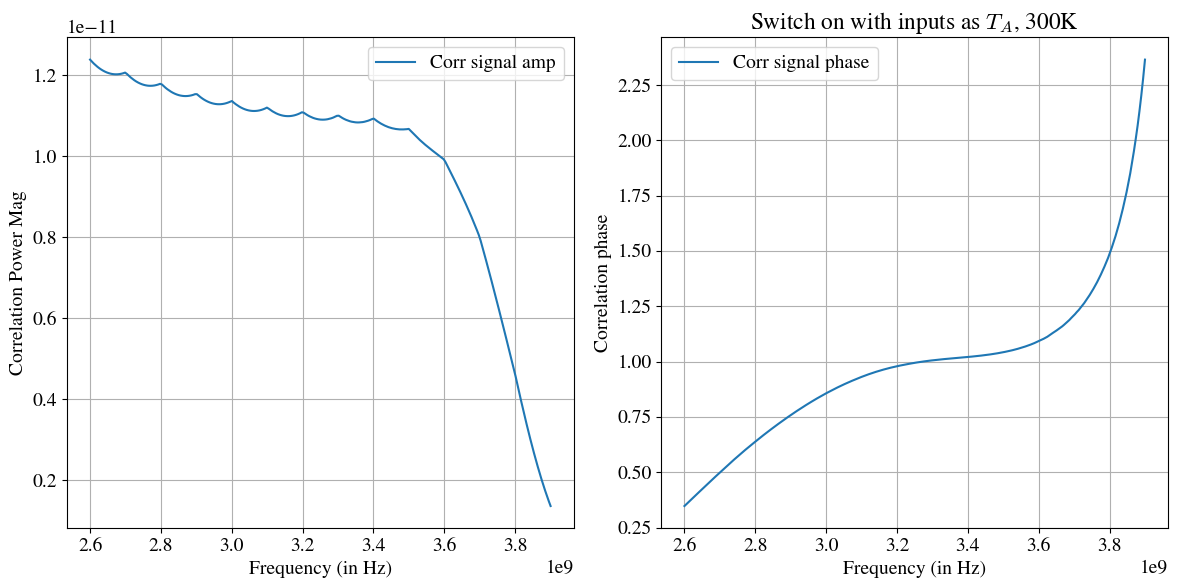

In [ ]:
#correlate the output
fig_corr, Tobs00 = correlator(input1=b2_top, input2=b2_bottom, x=apsera_freq)
plt.title('Switch on with inputs as $T_{A}$, 300K')

### T_obs, 300K ---> Off, non-ideal

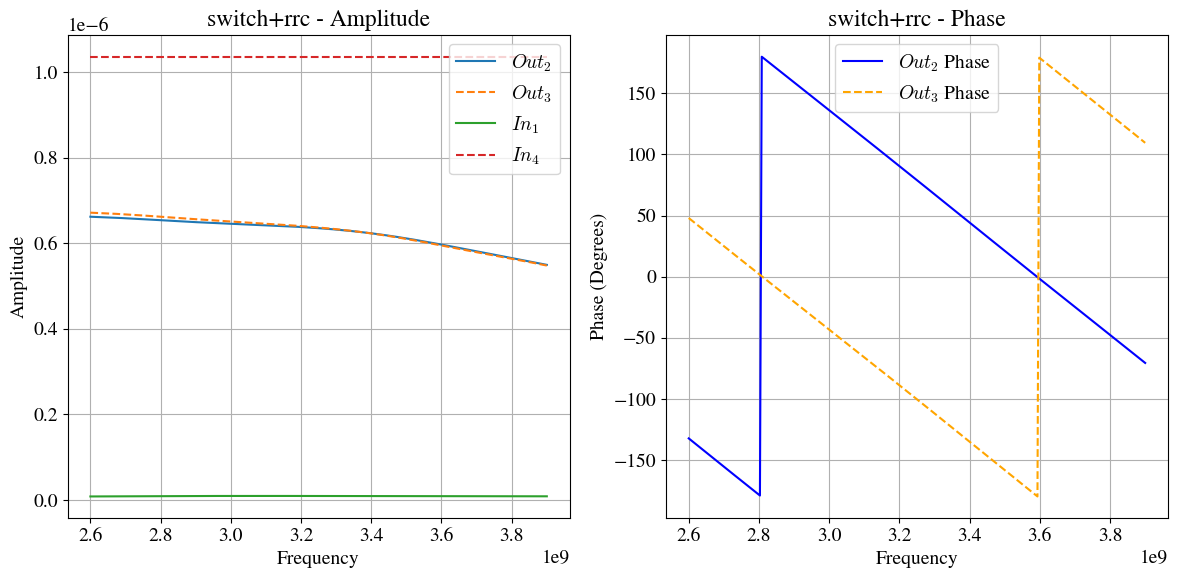

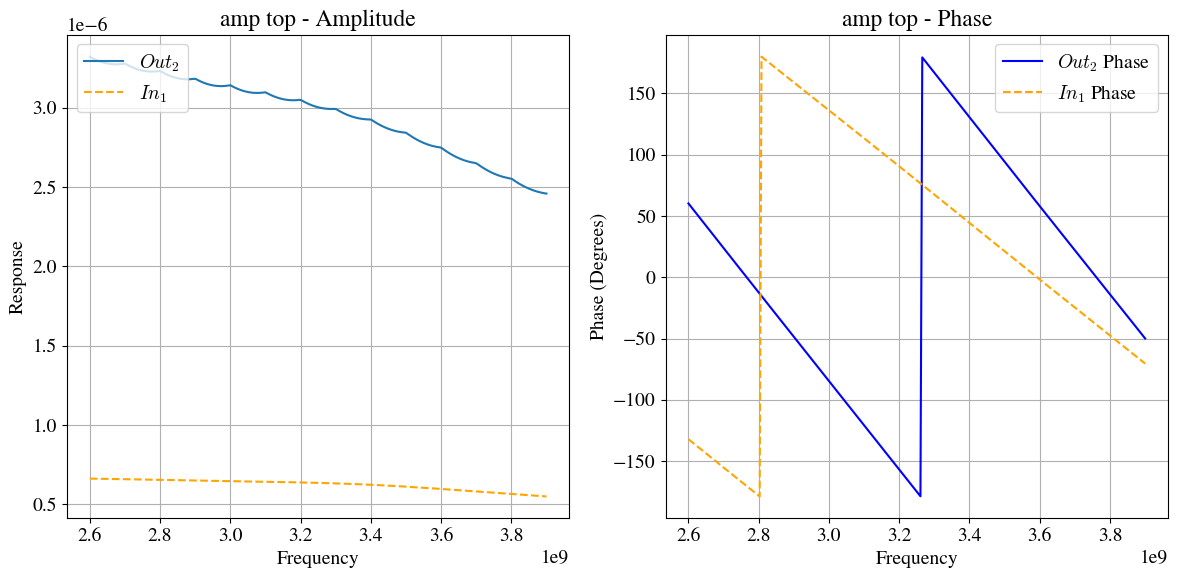

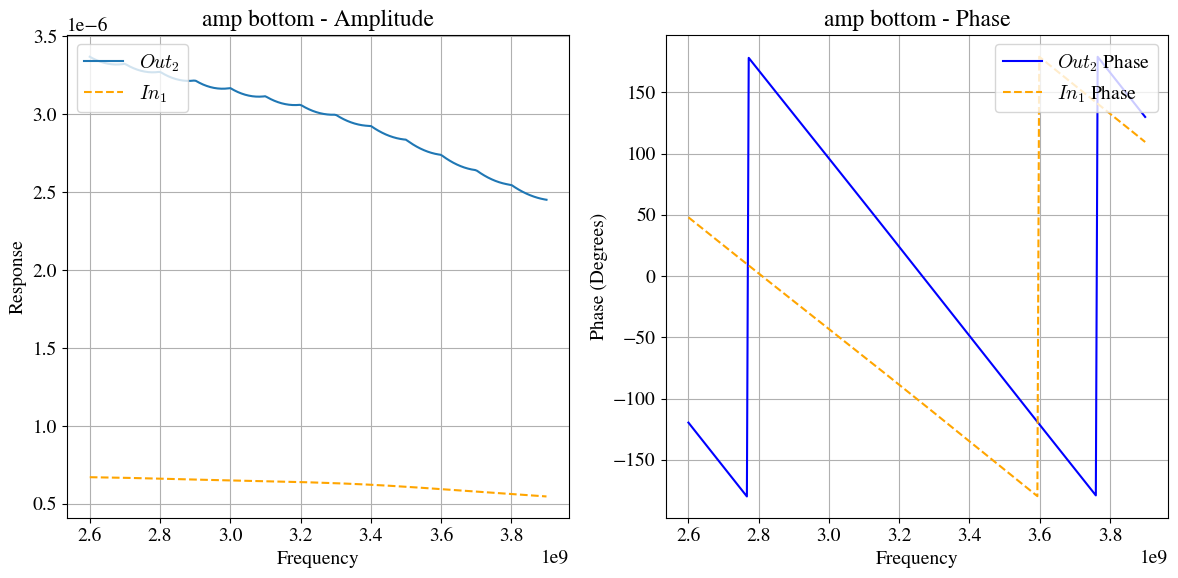

In [ ]:
# two inputs ---> switch + rrc(splits) + amplifier ---> two separate output
fig_switch_rrc_off, b2_rrc_off, b3_rrc_off = chain4ports(
    title='switch+rrc', 
    devices_sparam_list=[switch_off, rrc], 
    input1=V_nu_amp, 
    input2=noise_300, 
    cross_input=[0,0], 
    freq_=apsera_freq     )

fig_amptop_off, b2_top_off = chain2ports(
    title='amp top', 
    devices_sparam_list=[amp], 
    input1=b2_rrc_off, 
    freq_=apsera_freq    )

fig_ampbottom_off, b2_bottom_off = chain2ports(
    title='amp bottom', 
    devices_sparam_list=[amp], 
    input1=b3_rrc_off, 
    freq_=apsera_freq    )

### Correlate

Text(0.5, 1.0, 'Switch off with inputs as $T_{A}$, 300K')

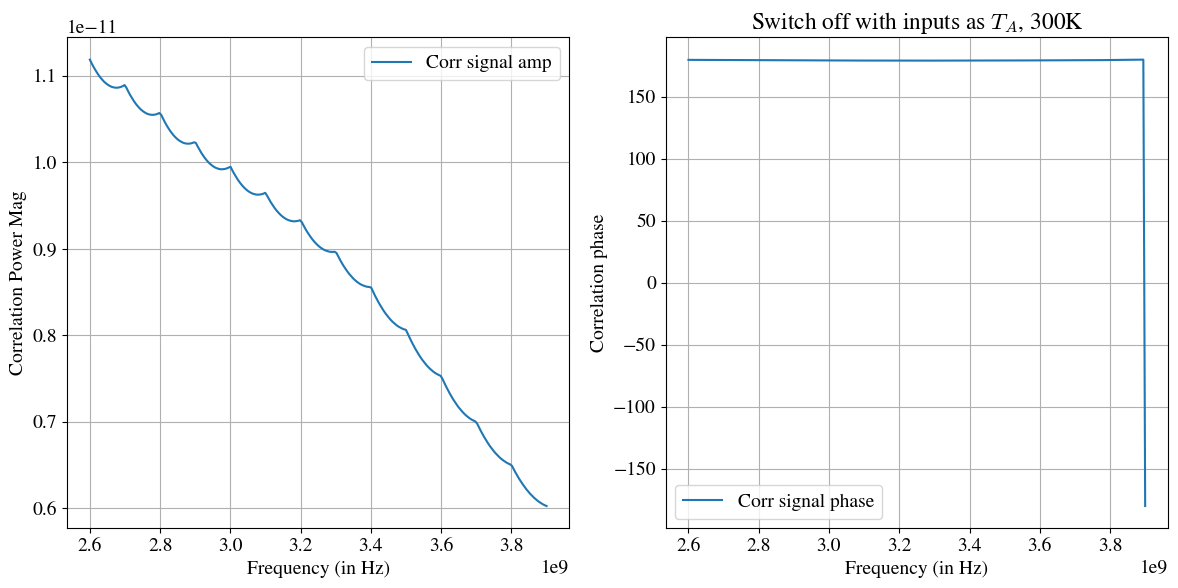

In [ ]:
#correlate the output
fig_corr, Tobs01 = correlator(input1=b2_top_off, input2=b2_bottom_off, x=apsera_freq)
plt.title('Switch off with inputs as $T_{A}$, 300K')

### Get T_obs 

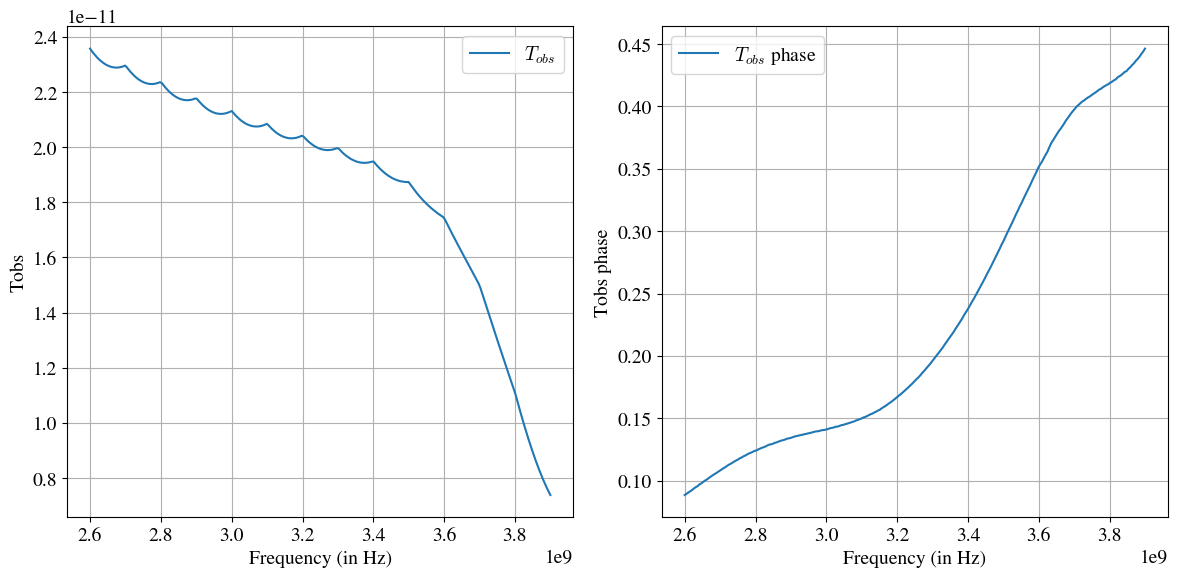

In [ ]:
Tobs = Tobs00 - Tobs01

# Create a 1x2 grid for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Correlation amplitude
axs[0].plot(apsera_freq, (Tobs), label='$T_{obs}$')
axs[0].set_ylabel('Tobs')
axs[0].set_xlabel('Frequency (in Hz)')
axs[0].grid()
axs[0].legend()

# Second plot: Correlation phase
axs[1].plot(apsera_freq, np.degrees(np.angle(Tobs)), label='$T_{obs}$ phase')
axs[1].set_ylabel('Tobs phase')
axs[1].set_xlabel('Frequency (in Hz)')
axs[1].grid()
axs[1].legend()

# Adjust layout to prevent overlap
fig.tight_layout()